# Summary of the assignment
<p> (1) Dataset: cifar10 </p>
<p> (2) Problem type: multi-class classification </p>
<p> (3) Hyper Modal Tuning </p>
<p> (4) 3-fold cross validation </p>

In [4]:
pip install keras-tuner

In [7]:
! rm -r dl03

rm: cannot remove 'dl03': No such file or directory


In [10]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import os
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Set seed for reproducibility
seed = 1404
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

# Load and preprocess CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train_scaled = X_train_all.astype('float32') / 255.0

# Flatten images
X_train_flat = np.array([x.flatten() for x in X_train_scaled])
X_test_flat = np.array([x.flatten() for x in X_test])

print(X_train_flat.shape, y_train.shape)  # (45000, 3072) (45000, 1)
print(X_test_flat.shape, y_test.shape)    # (10000, 3072) (10000, 1)

# Define model builder function
def build_model(hp):
    n_hidden = hp.Int('layers', min_value=1, max_value=8)
    n_units = hp.Int('units', min_value=32, max_value=256, step=32)
    af = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])

    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD()
    else:
        optimizer = tf.keras.optimizers.Adam()

    model = Sequential()
    model.add(Input(shape=(3072,)))  # Explicit input layer

    for _ in range(n_hidden):
        model.add(Dense(n_units, activation=af))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Fixed implementation with proper model reinitialization
best_val_acc = 0
best_hp = None

# Number of trials to run
max_trials = 4
trials = []

# Generate hyperparameter combinations manually
for trial_id in range(max_trials):
    print(f"\n=== Trial {trial_id+1}/{max_trials} ===")

    # Generate random hyperparameters
    hp = kt.HyperParameters()
    layers = hp.Int('layers', min_value=1, max_value=8)
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])

    # Store actual values for this trial
    trial_params = {
        'layers': layers,
        'units': units,
        'activation': activation,
        'optimizer': optimizer
    }

    # 3-fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=seed)
    fold_val_accs = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_flat)):
        print(f"\nFold {fold+1}/3")
        X_train_fold, X_val_fold = X_train_flat[train_idx], X_train_flat[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Build a NEW model for each fold
        model = build_model(hp)

        # Train model
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=5,
            batch_size=32,
            verbose=1
        )
        fold_histories.append(history.history)
        fold_val_accs.append(history.history['val_accuracy'][-1])

    # Calculate mean validation accuracy
    mean_val_acc = np.mean(fold_val_accs)
    print(f"\nTrial {trial_id+1} - Mean Validation Accuracy: {mean_val_acc:.4f}")

    # Save trial results
    trials.append({
        'hyperparameters': trial_params,
        'mean_val_acc': mean_val_acc,
        'histories': fold_histories
    })

    # Track best hyperparameters
    if mean_val_acc > best_val_acc:
        best_val_acc = mean_val_acc
        best_hp = trial_params

# Print best hyperparameters
print("\nBest Hyperparameters:")
print(f"Layers: {best_hp['layers']}")
print(f"Units: {best_hp['units']}")
print(f"Activation: {best_hp['activation']}")
print(f"Optimizer: {best_hp['optimizer']}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

# Create HyperParameters object for best config
best_hp_obj = kt.HyperParameters()
best_hp_obj.Fixed('layers', best_hp['layers'])
best_hp_obj.Fixed('units', best_hp['units'])
best_hp_obj.Fixed('activation', best_hp['activation'])
best_hp_obj.Fixed('optimizer', best_hp['optimizer'])

# Train final model on full training set with best hyperparameters
print("\nTraining final model on full training set...")
final_model = build_model(best_hp_obj)
final_history = final_model.fit(
    X_train_flat, y_train,
    validation_data=(X_valid_flat, y_valid),
    epochs=10,
    batch_size=32,
    verbose=1
)

(50000, 3072) (50000, 1)
(10000, 3072) (10000, 1)

=== Trial 1/4 ===

Fold 1/3
Epoch 1/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1538 - loss: 2.2301 - val_accuracy: 0.1771 - val_loss: 2.1265
Epoch 2/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1735 - loss: 2.1228 - val_accuracy: 0.1821 - val_loss: 2.0930
Epoch 3/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1762 - loss: 2.0954 - val_accuracy: 0.1786 - val_loss: 2.0759
Epoch 4/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1743 - loss: 2.0839 - val_accuracy: 0.1806 - val_loss: 2.0688
Epoch 5/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1758 - loss: 2.0768 - val_accuracy: 0.1789 - val_loss: 2.0645

Fold 2/3
Epoch 1/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1765 - loss: 2.1691 - val_accuracy: 0.2105 - val_loss: 2.0485
Epoch 2/5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2200 - loss: 2.0439 - val_accuracy: 0.2353 - val_loss: 2.0128
Epoch 3


Plotting training history...


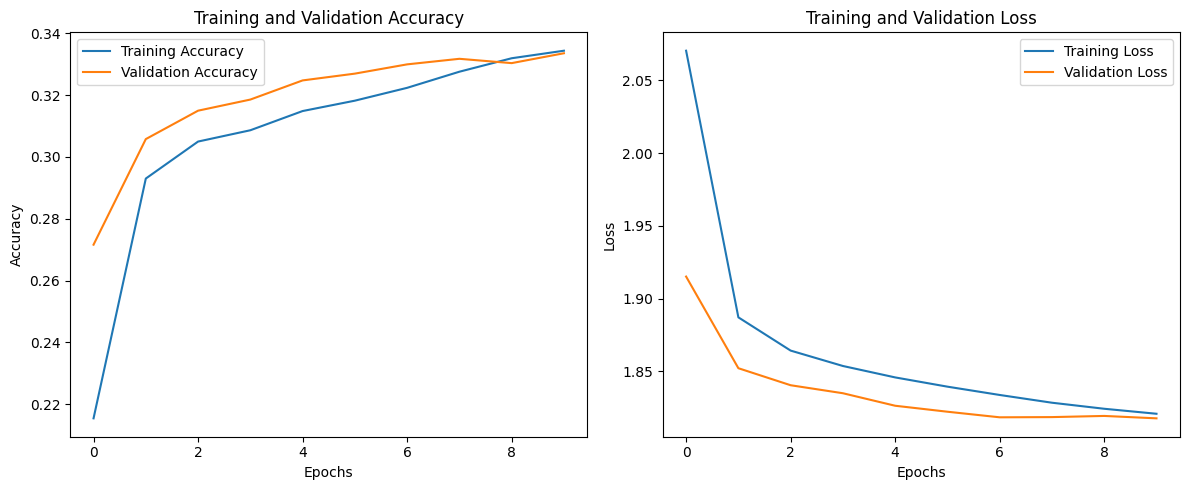


Evaluating on test set...
Test Accuracy: 0.2335
Test Loss: 263.3069
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.35      0.25      1000
           1       0.35      0.16      0.22      1000
           2       0.22      0.06      0.09      1000
           3       0.19      0.01      0.01      1000
           4       0.29      0.17      0.21      1000
           5       0.19      0.36      0.25      1000
           6       0.29      0.01      0.03      1000
           7       0.36      0.11      0.17      1000
           8       0.22      0.85      0.35      1000
           9       0.35      0.26      0.30      1000

    accuracy                           0.23     10000
   macro avg       0.27      0.23      0.19     10000
weighted avg       0.27      0.23      0.19     10000

Model saved as 'cifar10_best_model.keras'


In [11]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

print("\nPlotting training history...")
plot_history(final_history)

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc = final_model.evaluate(X_test_flat, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate classification report
y_pred = final_model.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Save model
final_model.save('cifar10_best_model.keras')
print("Model saved as 'cifar10_best_model.keras'")